In [1]:
!wget https://liveproject-resources.s3.amazonaws.com/other/MelanomaDetection.zip

--2020-08-16 19:19:51--  https://liveproject-resources.s3.amazonaws.com/other/MelanomaDetection.zip
Resolving liveproject-resources.s3.amazonaws.com (liveproject-resources.s3.amazonaws.com)... 52.216.113.35
Connecting to liveproject-resources.s3.amazonaws.com (liveproject-resources.s3.amazonaws.com)|52.216.113.35|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6296754 (6.0M) [application/zip]
Saving to: ‘MelanomaDetection.zip’

MelanomaDetection.z 100%[===================>]   6.00M  11.1MB/s    in 0.5s    

2020-08-16 19:19:52 (11.1 MB/s) - ‘MelanomaDetection.zip’ saved [6296754/6296754]



In [2]:
import os
os.makedirs('dataset',exist_ok=True)
!unzip MelanomaDetection.zip -d dataset


Streaming output truncated to the last 5000 lines.
  inflating: dataset/MelanomaDetection/unlabeled/1906.jpg  
  inflating: dataset/MelanomaDetection/unlabeled/1735.jpg  
  inflating: dataset/MelanomaDetection/unlabeled/3122.jpg  
  inflating: dataset/MelanomaDetection/unlabeled/4895.jpg  
  inflating: dataset/MelanomaDetection/unlabeled/5553.jpg  
  inflating: dataset/MelanomaDetection/unlabeled/5235.jpg  
  inflating: dataset/MelanomaDetection/unlabeled/3644.jpg  
  inflating: dataset/MelanomaDetection/unlabeled/1053.jpg  
  inflating: dataset/MelanomaDetection/unlabeled/1047.jpg  
  inflating: dataset/MelanomaDetection/unlabeled/6728.jpg  
  inflating: dataset/MelanomaDetection/unlabeled/5221.jpg  
  inflating: dataset/MelanomaDetection/unlabeled/3888.jpg  
  inflating: dataset/MelanomaDetection/unlabeled/3650.jpg  
  inflating: dataset/MelanomaDetection/unlabeled/4659.jpg  
  inflating: dataset/MelanomaDetection/unlabeled/3136.jpg  
  inflating: dataset/MelanomaDetection/unlabeled/

In [3]:
from glob import glob

# train_list = glob('dataset/MelanomaDetection/labeled/*')
# test_list = glob('dataset/MelanomaDetection/test/*')
# unlabelled_list = glob('dataset/MelanomaDetection/unlabeled/*')

In [4]:
# train_labels = [int(os.path.basename(os.path.join(i)).split('.')[0].split('_')[1]) for i in train_list]
# print(os.path.commonprefix(train_list))
# print(train_labels)

In [5]:
import cv2
import numpy as np
import torch
from torch.utils.data.dataset import Dataset
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt
from torchvision import transforms,models
from PIL import Image
import torchvision

class MelanomaDataset(Dataset):
    def __init__(self, 
                 file_names: str, 
                 train: bool = True,
                 transforms = None):
      
        super().__init__()

        self.image_ids = glob(file_names)
        self.transform = transforms
        self.train = train


    def __getitem__(self, index: int):
        image_id = self.image_ids[index]

        # image = cv2.imread(f'{image_id}', cv2.IMREAD_COLOR)
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)#.astype(np.float32)
        # # image /= 255.0
        # # image = torch.tensor(image)
        
        PIL_image = Image.open(image_id)
        
      
        if self.train:
          target = int(image_id.split('.')[0].split('_')[1])
        else:
          target = int(image_id.split('.')[0].split('_')[1])

          
        if self.transform:
            PIL_image = self.transform(PIL_image)
        else:
            test_transformation = transforms.Compose([
                    transforms.ToTensor(),
                    # transforms.Normalize((0.5,0.5,0.5),
                    #                      (0.5,0.5,0.5)),
      
                                ])
            PIL_image = test_transformation(PIL_image)
            
        return PIL_image,target

    def __len__(self) -> int:
        return len(self.image_ids)

In [6]:
rotation = transforms.RandomChoice([transforms.RandomRotation([-3,3]),
                                    transforms.RandomRotation([87,93]), 
                                    transforms.RandomRotation([177,183]),
                                    transforms.RandomRotation([267, 273])])

In [7]:
train_transformation = transforms.Compose([
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomVerticalFlip(),
                    rotation,
                    transforms.ToTensor(),
                    # transforms.Normalize((0.5,0.5,0.5),
                    #                      (0.5,0.5,0.5)),
      
                                ])

In [8]:
test_transformation = transforms.Compose([
                    transforms.ToTensor(),
                    # transforms.Normalize((0.5,0.5,0.5),
                    #                      (0.5,0.5,0.5)),
      
                                ])

In [9]:
train_dataset = MelanomaDataset('dataset/MelanomaDetection/labeled/*',
                                  
                                   train=True,
                                   transforms = train_transformation,

                                   )

In [10]:
test_dataset = MelanomaDataset('dataset/MelanomaDetection/test/*',
                                  
                                   train=False,
                                   transforms = test_transformation,

                                   )

In [11]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=4,
                                               pin_memory=True,
                                               num_workers=6,
                                               shuffle=True
                                               )

In [12]:
test_loader = torch.utils.data.DataLoader(test_dataset,
                                               batch_size=4,
                                               pin_memory=True,
                                               num_workers=6
                                               
                                               )

In [13]:
img,_ = next(iter(train_loader))
_
# img.shape

tensor([0, 0, 1, 0])

In [14]:
# plt.imshow(img[0].permute( 2, 1,0))

tensor([0, 0, 1, 0])


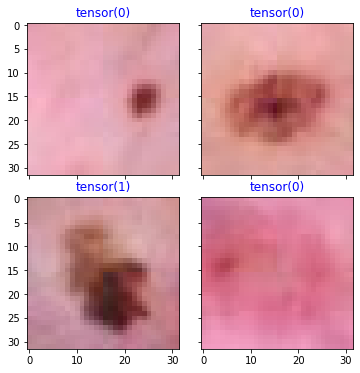

In [15]:
def _make_grid(image_path_list,label,n_row=2, n_col=2,fig_size=(6,6)):
    fig = plt.figure(figsize=fig_size)
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(n_row,n_col),  # creates 2x2 grid of axes
                     axes_pad=0.3,  # pad between axes in inch.
                     )
    print(label)
    for ax,fname,title in zip(grid, image_path_list,label):
        # Iterating over the grid returns the Axes.
        # im= plt.imread(fname)
        # file_name = fname.split('/')[-1]
        ax.imshow(fname.permute( 2, 1,0))
        ax.set_title(title,color='blue')

    plt.show()

_make_grid(img,_,n_row=2, n_col=2,fig_size=(6,6))

tensor([0, 1, 1, 1])


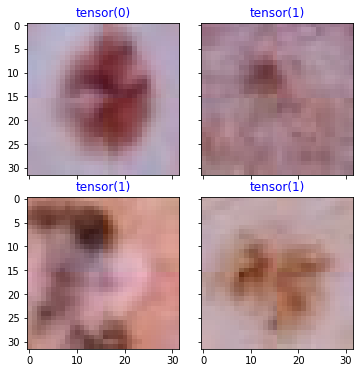

In [16]:
img,_ = next(iter(test_loader))
_make_grid(img,_,n_row=2, n_col=2,fig_size=(6,6))

In [17]:
class UnlabelledMelanomaDataset(Dataset):
    def __init__(self, 
                 file_names: list, 
                 transforms = None):
      
        super().__init__()

        self.image_ids = glob(file_names)
        self.transform = transforms



    def __getitem__(self, index: int):
        image_id = self.image_ids[index]

        
        PIL_image = Image.open(image_id)

        if self.transform:
            PIL_image = self.transform(PIL_image)
        return PIL_image

    def __len__(self) -> int:
        return len(self.image_ids)

In [18]:
unlabelled_dataset = UnlabelledMelanomaDataset('dataset/MelanomaDetection/unlabeled/*', transforms = test_transformation)
print('Number of images in the set: ', len(unlabelled_dataset))

Number of images in the set:  7018


In [19]:
unlabelled_loader = torch.utils.data.DataLoader(unlabelled_dataset,
                                               batch_size=4,
                                               pin_memory=True,
                                               num_workers=6,
                                               shuffle=True
                                               )

Shape of batch  0 :  torch.Size([4, 3, 32, 32])


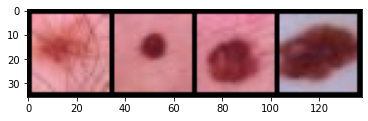

Shape of batch  1 :  torch.Size([4, 3, 32, 32])


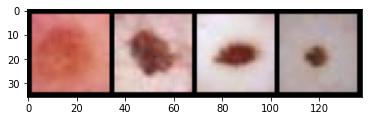

In [20]:

for batch_idx, batch in enumerate(unlabelled_loader):
    
    # Stop after two batches
    if batch_idx == 2:
        break

    print("Shape of batch ", batch_idx, ": ", batch.shape)
    image_grid = torchvision.utils.make_grid(batch, nrow=4)
    plt.imshow(image_grid.permute(1, 2, 0))
    plt.pause(0.05)

In [44]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=4,
                                               pin_memory=True,
                                               num_workers=6,
                                               shuffle=True
                                               )



test_loader = torch.utils.data.DataLoader(test_dataset,
                                               batch_size=4,
                                               pin_memory=True,
                                               num_workers=6,
                                          shuffle=True
                                               
                                               )

unlabelled_loader = torch.utils.data.DataLoader(unlabelled_dataset,
                                               batch_size=4,
                                               pin_memory=True,
                                               num_workers=6,
                                               shuffle=True
                                               )

In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

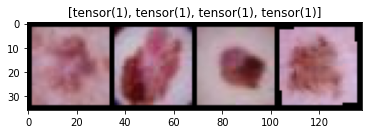

In [34]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    # mean = np.array([0.485, 0.456, 0.406])
    # std = np.array([0.229, 0.224, 0.225])
    # inp = std * inp + mean
    # inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[x for x in classes])

Training the model

In [23]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloaders = train_loader
                image_data= train_dataset
            else:
                model.eval()   # Set model to evaluate mode
                dataloaders = test_loader
                image_data= test_dataset

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(image_data)
            epoch_acc = running_corrects.double() / len(image_data)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


In [47]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                # print(labels[j].item())
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('real: {} predicted: {}'.format(labels[j].item(),preds[j].item()))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [57]:
import torch.nn as nn
from torch import optim
from torch.optim import lr_scheduler
model_ft = models.resnet152(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0009)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/hub/checkpoints/resnet152-b121ed2d.pth


In [58]:
import time
import copy
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=100)

Epoch 0/99
----------
train Loss: 1.2692 Acc: 0.5400
val Loss: 0.8360 Acc: 0.5183

Epoch 1/99
----------
train Loss: 0.7944 Acc: 0.5750
val Loss: 0.5946 Acc: 0.6817

Epoch 2/99
----------
train Loss: 0.7526 Acc: 0.5700
val Loss: 0.7454 Acc: 0.5400

Epoch 3/99
----------
train Loss: 0.7252 Acc: 0.6200
val Loss: 0.6324 Acc: 0.6683

Epoch 4/99
----------
train Loss: 0.7106 Acc: 0.6450
val Loss: 0.6062 Acc: 0.6267

Epoch 5/99
----------
train Loss: 0.7841 Acc: 0.6050
val Loss: 0.5929 Acc: 0.6667

Epoch 6/99
----------
train Loss: 0.7004 Acc: 0.6250
val Loss: 0.8909 Acc: 0.5450

Epoch 7/99
----------
train Loss: 0.6584 Acc: 0.6250
val Loss: 0.5961 Acc: 0.7367

Epoch 8/99
----------
train Loss: 0.6223 Acc: 0.6900
val Loss: 0.6169 Acc: 0.6800

Epoch 9/99
----------
train Loss: 0.5873 Acc: 0.6700
val Loss: 0.5697 Acc: 0.7350

Epoch 10/99
----------
train Loss: 0.5632 Acc: 0.7250
val Loss: 0.5460 Acc: 0.7383

Epoch 11/99
----------
train Loss: 0.5458 Acc: 0.7100
val Loss: 0.5220 Acc: 0.7550

Ep

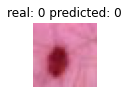

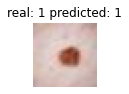

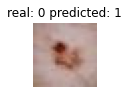

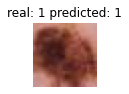

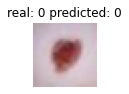

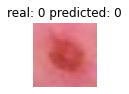

In [59]:
visualize_model(model_ft)

Model From Scratch

In [75]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(8 * 8 * 64, 1000)
        self.fc2 = nn.Linear(1000, 2)
    def forward(self, x):
      out = self.layer1(x)
      out = self.layer2(out)
      out = out.reshape(out.size(0), -1)
      out = self.drop_out(out)

      out = self.fc1(out)
      out = self.fc2(out)
      return out

In [78]:
model_scratch = ConvNet()
model_scratch.to(device)
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
criterion.to(device)
optimizer = torch.optim.Adam(model_scratch.parameters(), lr=.001)


exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [80]:
model_scratch = train_model(model_scratch, criterion, optimizer, exp_lr_scheduler, num_epochs=100)

Epoch 0/99
----------
train Loss: 0.5378 Acc: 0.7450
val Loss: 0.5475 Acc: 0.7300

Epoch 1/99
----------
train Loss: 0.5326 Acc: 0.7450
val Loss: 0.5475 Acc: 0.7300

Epoch 2/99
----------
train Loss: 0.5350 Acc: 0.7600
val Loss: 0.5475 Acc: 0.7300

Epoch 3/99
----------
train Loss: 0.5342 Acc: 0.7500
val Loss: 0.5475 Acc: 0.7300

Epoch 4/99
----------
train Loss: 0.5335 Acc: 0.7600
val Loss: 0.5475 Acc: 0.7300

Epoch 5/99
----------
train Loss: 0.5286 Acc: 0.7600
val Loss: 0.5475 Acc: 0.7300

Epoch 6/99
----------
train Loss: 0.5370 Acc: 0.7400
val Loss: 0.5475 Acc: 0.7300

Epoch 7/99
----------
train Loss: 0.5351 Acc: 0.7450
val Loss: 0.5475 Acc: 0.7300

Epoch 8/99
----------
train Loss: 0.5343 Acc: 0.7500
val Loss: 0.5475 Acc: 0.7300

Epoch 9/99
----------
train Loss: 0.5358 Acc: 0.7500
val Loss: 0.5475 Acc: 0.7300

Epoch 10/99
----------
train Loss: 0.5389 Acc: 0.7550
val Loss: 0.5475 Acc: 0.7300

Epoch 11/99
----------
train Loss: 0.5377 Acc: 0.7500
val Loss: 0.5475 Acc: 0.7300

Ep

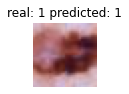

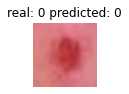

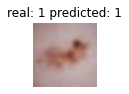

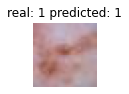

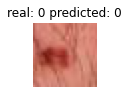

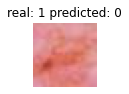

In [81]:
visualize_model(model_scratch)

Epoch 0/99
----------
train Loss: 1.8831 Acc: 0.5250
val Loss: 1.8308 Acc: 0.5100

Epoch 1/99
----------
train Loss: 1.2250 Acc: 0.4550
val Loss: 5.2218 Acc: 0.5000

Epoch 2/99
----------
train Loss: 0.9324 Acc: 0.5500
val Loss: 7.3803 Acc: 0.5350

Epoch 3/99
----------
train Loss: 1.0135 Acc: 0.4850
val Loss: 2.1693 Acc: 0.5867

Epoch 4/99
----------
train Loss: 1.2512 Acc: 0.4850
val Loss: 5.6253 Acc: 0.5033

Epoch 5/99
----------
train Loss: 0.8696 Acc: 0.6200
val Loss: 4.7777 Acc: 0.5350

Epoch 6/99
----------
train Loss: 0.7772 Acc: 0.6350
val Loss: 9.7214 Acc: 0.5967

Epoch 7/99
----------
train Loss: 0.6472 Acc: 0.6200
val Loss: 9.9860 Acc: 0.6033

Epoch 8/99
----------
train Loss: 0.6814 Acc: 0.6050
val Loss: 5.5272 Acc: 0.5467

Epoch 9/99
----------
train Loss: 0.6212 Acc: 0.6500
val Loss: 5.0310 Acc: 0.5583

Epoch 10/99
----------
train Loss: 0.6474 Acc: 0.6300
val Loss: 3.5641 Acc: 0.5433

Epoch 11/99
----------
train Loss: 0.6435 Acc: 0.6650
val Loss: 4.8679 Acc: 0.5600

Ep

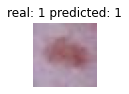

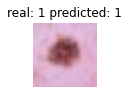

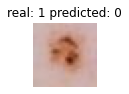

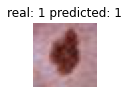

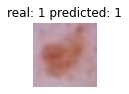

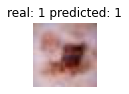

In [82]:
model_ft = models.resnet152(pretrained=False)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0009)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=100)
visualize_model(model_ft)

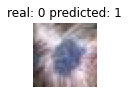

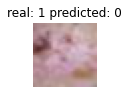

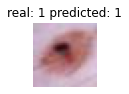

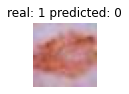

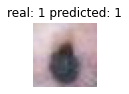

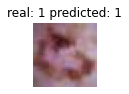

In [83]:
visualize_model(model_ft)

Accuracy Scores

* Transfer Learning (Pretrained Weights)-.77
* Conv Network from Scratch - .73
* Transfer learning(without pretrained wieghts) - .65
